
# Workshop: Clustering Genomic Sequences with Neural Networks

### Overview and Learning Goals
In this workshop, we will train a neural network model to cluster genomic sequences using unsupervised learning techniques. Through this tutorial, we’ll explore the following:

- Setting up data and model configurations
- Initializing a neural network model with contrastive training
- Evaluating clustering quality with confusion matrices and UMAP visualizations

---

#### Key Sections:
1. **Setup and Data Summary**
2. **Model Initialization and Training**
3. **Generating Predictions and Evaluating Clusters**
4. **Visualizing Clustering in Latent Space**

**Prerequisites**:
This tutorial assumes familiarity with Python, PyTorch, and concepts in unsupervised learning.


In [ ]:
#!git clone https://github.com/Kari-Genomics-Lab/iDeLUCS.git

In [ ]:
#!cd iDeLUCS/ && python setup.py build_ext --inplace && pip install -e .

#Colab will only give you 2 cores
#!sed -i 's/torch.set_num_threads(cpu_count() - 2 )/torch.set_num_threads(cpu_count())/g' iDeLUCS/idelucs/__main__.py

In [ ]:
#!idelucs -h


## Section 1: Setup and Data Summary

In this section, we'll load and summarize the genomic sequence data to understand its structure and characteristics.


In [1]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import time
from utils import SummaryFasta

# Define function for initializing weights
def weights_init(m):
    """Kaiming initialization for neural network weights."""
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

# Sample configurations
args = {
    'sequence_file': 'train_data.fasta',
    'GT_file': None,
    'n_clusters': 15,
    'n_epochs': 100,
    'batch_sz': 256,
    'k': 6,
    'model_size': 'linear',
    'n_mimics': 3
}


In [2]:
import models 
# Load and summarize data
model = models.IID_model(args)  # Instantiate model
model.names, model.lengths, model.GT, model.cluster_dis = SummaryFasta(model.sequence_file, model.GT_file)

# Print data summary
stats = {
    "n_seq": len(model.lengths),
    "min_len": np.min(model.lengths),
    "max_len": np.max(model.lengths),
    "avg_len": np.mean(model.lengths)
}
print(f"No. Sequences: {stats['n_seq']}")
print(f"Min Length: {stats['min_len']}")
print(f"Max Length: {stats['max_len']}")
print(f"Avg Length: {stats['avg_len']:.2f}")


No. Sequences: 909
Min Length: 8003
Max Length: 9839
Avg Length: 8903.33



## Section 2: Model Initialization and Training

In this section, we'll initialize our neural network model, set up the data loader, and train the model with contrastive learning.


In [3]:
# Initialize model weights
model.net.apply(weights_init)

# Build DataLoader
model.build_dataloader()

# Confirm dataloader setup
print("Dataloader built. Example batch:")
for batch in model.dataloader:
    print(batch)
    break  # Display only the first batch


Dataloader built. Example batch:
{'true': tensor([[-0.1386,  0.0641, -0.2222,  ..., -0.5703, -0.7548, -0.1389],
        [ 0.1653,  0.0801,  0.1987,  ...,  0.5692,  2.3873, -0.1251],
        [ 2.1629,  0.8263,  0.0555,  ...,  0.7899,  0.4531, -1.9879],
        ...,
        [-0.0802, -0.4448,  0.2591,  ..., -1.6530, -1.7774, -0.0939],
        [ 0.1613,  0.6315,  0.1931,  ..., -0.5575, -0.7468, -0.1280],
        [-2.4978, -0.6465, -1.2589,  ...,  0.2918,  0.1059,  0.5940]]), 'modified': tensor([[-0.1386, -0.4884,  0.1720,  ..., -0.5703,  0.2842,  0.8114],
        [ 0.4911, -0.4494,  0.6499,  ..., -0.5229,  1.3820, -0.0986],
        [ 1.0090, -0.3104, -0.7313,  ..., -0.3542,  0.4851, -0.9667],
        ...,
        [-0.0450, -0.4185,  0.3117,  ..., -1.6317, -1.7675,  0.9076],
        [-0.4103,  0.6315, -0.5984,  ...,  0.5647, -0.7468, -0.1280],
        [-1.6739, -1.1493, -1.9733,  ..., -0.7347,  1.1195,  0.6251]])}


>### Question: Why does batch contains two tensors?

In [4]:
# Run the training loop for a few epochs
model_loss = []
for epoch in range(5):  # Change to args['n_epochs'] for full training
    loss = model.contrastive_training_epoch()
    model_loss.append(loss)
    print(f"Epoch {epoch + 1} / {args['n_epochs']}, Loss: {loss}")


Epoch 1 / 100, Loss: 0.10000000149011612
Epoch 2 / 100, Loss: 0.10000000149011612
Epoch 3 / 100, Loss: 0.10000000149011612
Epoch 4 / 100, Loss: 0.10000000149011612
Epoch 5 / 100, Loss: 0.10000000149011612



## Section 3: Generating Predictions and Evaluating Clusters

After training, we can generate predictions for each sequence and evaluate the clustering quality by comparing predicted labels with ground truth.


In [5]:

# Predict cluster assignments and latent representations
y_pred, probabilities, latent = model.predict()

# Display some predictions and their confidence scores
print("Predictions and confidence scores (first 10 samples):")
for i in range(10):
    print(f"Sequence ID: {model.names[i]}, Assigned Cluster: {y_pred[i]}, Confidence: {probabilities[i]:.2f}")


Predictions and confidence scores (first 10 samples):
Sequence ID: >sample_650|A1D, Assigned Cluster: 2, Confidence: 0.19
Sequence ID: >sample_531|A1CD, Assigned Cluster: 8, Confidence: 0.24
Sequence ID: >sample_231|02_AG, Assigned Cluster: 6, Confidence: 0.39
Sequence ID: >sample_26|01B, Assigned Cluster: 6, Confidence: 0.38
Sequence ID: >sample_1179|D, Assigned Cluster: 6, Confidence: 0.36
Sequence ID: >sample_776|A6, Assigned Cluster: 4, Confidence: 0.22
Sequence ID: >sample_358|A1, Assigned Cluster: 6, Confidence: 0.32
Sequence ID: >sample_482|A1C, Assigned Cluster: 14, Confidence: 0.23
Sequence ID: >sample_145|01_AE, Assigned Cluster: 4, Confidence: 0.14
Sequence ID: >sample_879|B, Assigned Cluster: 7, Confidence: 0.31



## Section 4: Visualizing Clustering in Latent Space

Using UMAP, we can project the latent space into 2D and visualize the clustering results.


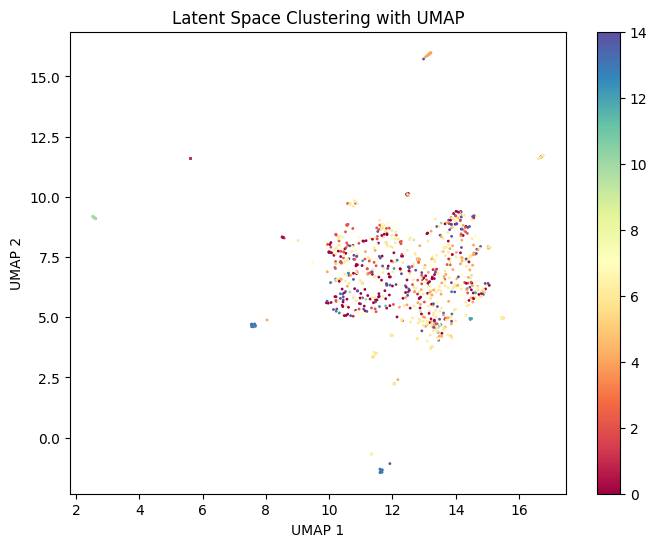

In [6]:

import umap

# Use UMAP to visualize latent space clustering
embedding = umap.UMAP(random_state=42).fit_transform(latent)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_pred, cmap='Spectral', s=1)
plt.colorbar()
plt.title("Latent Space Clustering with UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


>### Questions:

1. Inspect the code definition of the IID model in the file `models.py` to see which relevant parts of the pipeline are missing.
2. Implement the training loop. **Hint**: Consider the special clustering loss functions in the file `LossFunctions.py` 
3. Implement the missing data augmentation in the file `utils.py` 
4. What are some ideas discussed in class to improve the clustering?

In [7]:

# Plot confusion matrix if ground truth is available
from utils import plot_confusion_matrix, compute_results

if model.GT is not None:
    y_true = [model.GT[i] for i in range(len(y_pred))]
    w, _ = compute_results(y_pred, latent, y_true)
    fig, ax = plt.subplots()
    plot_confusion_matrix(w, unique_labels=model.cluster_dis.keys(), ax=ax, normalize=False)
    plt.show()
